In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import utils

import data_collections

In [3]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.15:34317 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


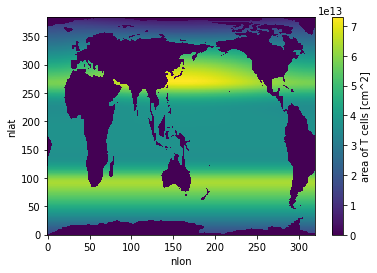

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [5]:
coll = data_collections.epoch_mean(
    query=dict(experiment='historical', stream='pop.h.ecosys.nyear1'),
)
dsets = coll.to_dataset_dict(['DOCt_FLUX_IN_100m'], clobber=False)
_, ds = dsets.popitem()
ds = ds.compute()
ds

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


<xarray.Dataset>
Dimensions:                 (member_id: 11, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    ULONG                   (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
    ULAT                    (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    TLONG                   (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                    (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
  * member_id               (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/51)
    DOCt_FLUX_IN_100m       (member_id, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    grav                    float64 980.6
    ocn_ref_salinity        float64 34.7
    sound                   float64 1.5e+05
    rho_air                 float64 1.292
    sflux_factor            float64 0.1
    ...                      ...
    KMU                     (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    salt_to_ppt             float64 1e+03
    salt_to_Svppt           float64 1e-09
    ANGLE                   (nlat, nlon) float64 0.0 0.0 ... -0.0259 2.804e-07
    HTN                     (nlat, nlon) float64 2.397e+06 ... 1.391e+06
    days_in_norm_year       timedelta64[ns] 365 days

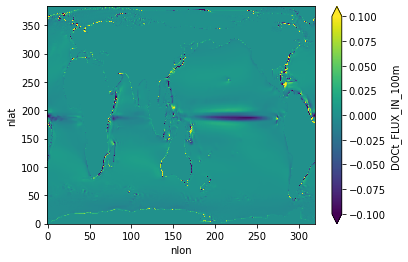

In [6]:
ds.DOCt_FLUX_IN_100m.mean('member_id').plot(vmin=-0.1, vmax=0.1)

In [7]:
nmols_to_PgCyr = 1e-9 * 12e-15 * 86400. * 365.
DOCt_FLUX_IN_100m_glbl = (ds.DOCt_FLUX_IN_100m.mean('member_id') * masked_area).sum(['nlat', 'nlon']) * nmols_to_PgCyr
print(
    f'Globally integrated DOC export: {DOCt_FLUX_IN_100m_glbl.values[0]:0.2f} PgC/yr')

Globally integrated DOC export: 1.91 PgC/yr


In [8]:
client.close()
cluster.close()
del client
del cluster

In [9]:
1.91/(1.91+7.1)

0.21198668146503885